<p align="center"><strong>Итоговый проект: Предсказание сердечно‑сосудистых заболеваний</strong></p>
  
**Среда:** Python 3, VS Code / Jupyter  
**Данные:** `train.csv` (600k×15), `test.csv` (400k×14), таргет — `class`

### 1. Импорт и настройка окружения

In [22]:
import time
from IPython.display import Markdown, display
from __future__ import annotations

import os
import json
import math
import random
from pathlib import Path
from typing import Tuple, Dict, Any, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams.update({"figure.figsize": (8, 5), "axes.grid": True})
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DATA_DIR = Path(".")
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"
CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

def set_seed(seed: int) -> None:
    """Фиксируем сид для воспроизводимости."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

### 2. Загрузка данных

In [23]:
def load_data(train_path: Path, test_path: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Загружает train и test CSV.

    Parameters
    ----------
    train_path : Path
        Путь к train.csv
    test_path : Path
        Путь к test.csv

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame]
        Датафреймы train, test
    """
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

train_df, test_df = load_data(TRAIN_PATH, TEST_PATH)
print(train_df.shape, test_df.shape)
display(train_df.head())
display(test_df.head())

(600000, 15) (400000, 14)


,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0


,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal
0,600000,53.963191,1,4.000000,136.940829,236.862814,0,2,143.961525,1,0.711100,1,2,7
1,600001,49.621479,1,4.000000,122.024651,226.593019,0,2,112.220874,1,0.000000,1,1,7
2,600002,36.933893,1,1.300924,127.585643,351.061046,0,0,177.945922,0,0.313078,1,0,7
3,600003,54.884588,1,3.000000,124.876745,250.370530,0,0,153.176526,0,0.308277,1,1,7
4,600004,71.016392,0,1.746972,120.922600,210.979710,0,0,164.573122,0,1.021370,1,1,3


### 3. Базовый анализ данных (EDA)

In [24]:
def describe_df(df: pd.DataFrame, name: str) -> None:
    """Выводит базовую информацию о датафрейме.

    Parameters
    ----------
    df : pd.DataFrame
        Датафрейм
    name : str
        Человекочитаемое имя набора
    """
    print(f"\n=== {name} INFO ===")
    print(df.info())
    print("\nОписание числовых признаков:\n", df.describe())

describe_df(train_df, "Train")


=== Train INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non

In [25]:

# === Приведение типов и экономия памяти ===
import pandas as pd, numpy as np

def _maybe_downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.select_dtypes(include=[np.number]).columns:
        if col == "class":
            continue
        if pd.api.types.is_float_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast="float")
        elif pd.api.types.is_integer_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast="integer")
    return df

def show_dtype_changes(df_before: pd.DataFrame, df_after: pd.DataFrame, title: str):
    b = df_before.dtypes.astype(str)
    a = df_after.dtypes.astype(str)
    ch = (b != a)
    changed = (a[ch]).to_frame("after").join(b[ch].to_frame("before"))
    display(Markdown(f"### Краткий вывод по типам — {title}"))
    if changed.empty:
        display(Markdown("- Явных изменений типов не потребовалось; типы уже оптимальны."))
    else:
        display(Markdown("- Типы приведены к компактным: float64→float32, int64→int32/16, категориальные — целочисленные."))
        display(changed[["before","after"]])

for _name in ["train_df", "test_df"]:
    if _name in globals():
        _df = globals()[_name]
        _before = _df.copy()
        globals()[_name] = _maybe_downcast_numeric(_df)
        show_dtype_changes(_before, globals()[_name], _name)


### Краткий вывод по типам — train_df

- Типы приведены к компактным: float64→float32, int64→int32/16, категориальные — целочисленные.

,before,after
ID,int64,int32
age,float64,float32
sex,int64,int8
chest,float64,float32
resting_blood_pressure,float64,float32
serum_cholestoral,float64,float32
fasting_blood_sugar,int64,int8
resting_electrocardiographic_results,int64,int8
maximum_heart_rate_achieved,float64,float32
exercise_induced_angina,int64,int8


### Краткий вывод по типам — test_df

- Типы приведены к компактным: float64→float32, int64→int32/16, категориальные — целочисленные.

,before,after
ID,int64,int32
age,float64,float32
sex,int64,int8
chest,float64,float32
resting_blood_pressure,float64,float32
serum_cholestoral,float64,float32
fasting_blood_sugar,int64,int8
resting_electrocardiographic_results,int64,int8
maximum_heart_rate_achieved,float64,float32
exercise_induced_angina,int64,int8


### 4. Признаки и целевая переменная

In [26]:
TARGET_COL = "class"
ID_COL = "ID"

assert TARGET_COL in train_df.columns, "В train.csv должен быть столбец 'class'"
assert ID_COL in train_df.columns, "Ожидается столбец 'ID'"
assert ID_COL in test_df.columns, "Ожидается столбец 'ID' в test.csv"

# Возможные категориальные признаки по описанию
candidate_cats = [
    "sex", "chest_bin", "slope", "resting_electrocardiographic_results",
    "thal", "fasting_blood_sugar", "exercise_induced_angina", "chest"
]
categorical = [c for c in candidate_cats if c in train_df.columns]
numeric = [c for c in train_df.columns if c not in categorical + [TARGET_COL, ID_COL]]

print("Категориальные:", categorical)
print("Числовые:", numeric)

Категориальные: ['sex', 'slope', 'resting_electrocardiographic_results', 'thal', 'fasting_blood_sugar', 'exercise_induced_angina', 'chest']
Числовые: ['age', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved', 'oldpeak', 'number_of_major_vessels']


### 5. Проверка и фильтрация невалидных значений

In [27]:
def filter_invalids(df: pd.DataFrame) -> pd.DataFrame:
    """Простой фильтр невалидных значений по здравому смыслу.

    Возвращает копию датафрейма с удалёнными грубо неверными строками.

    Notes
    -----
    Верхние/нижние границы заданы консервативно; при необходимости сузьте.
    """
    df = df.copy()
    # Примеры фильтров:
    if "age" in df.columns:
        df = df[(df["age"] >= 0) & (df["age"] <= 120)]
    if "resting_blood_pressure" in df.columns:
        df = df[(df["resting_blood_pressure"] >= 0) & (df["resting_blood_pressure"] <= 300)]
    if "serum_cholestoral" in df.columns:
        df = df[(df["serum_cholestoral"] >= 0) & (df["serum_cholestoral"] <= 1500)]
    if "maximum_heart_rate_achieved" in df.columns:
        df = df[(df["maximum_heart_rate_achieved"] >= 0) & (df["maximum_heart_rate_achieved"] <= 250)]
    if "oldpeak" in df.columns:
        df = df[(df["oldpeak"] >= -5) & (df["oldpeak"] <= 10)]
    return df

raw_rows = len(train_df)
train_df = filter_invalids(train_df)
print(f"Удалено строк: {raw_rows - len(train_df)}")

Удалено строк: 0


In [28]:

# Краткий вывод по проверке и фильтрации
from IPython.display import Markdown, display
if "train_df" in globals():
    removed_rows = int(globals().get("raw_rows", len(train_df)) - len(train_df))
    display(Markdown("### Краткий вывод по проверке и фильтрации"))
    display(Markdown(f"- Удалено строк: **{removed_rows}**; оставлено: **{len(train_df)}**."))
    display(Markdown("- Границы фильтров консервативны; при необходимости их можно сузить для более жёсткой очистки."))
else:
    display(Markdown("### Краткий вывод по проверке и фильтрации"))
    display(Markdown("- Примечание: сначала выполните шаг загрузки и очистки данных."))


### Краткий вывод по проверке и фильтрации

- Удалено строк: **0**; оставлено: **600000**.

- Границы фильтров консервативны; при необходимости их можно сузить для более жёсткой очистки.

### 6. Корреляционный анализ и визуализации

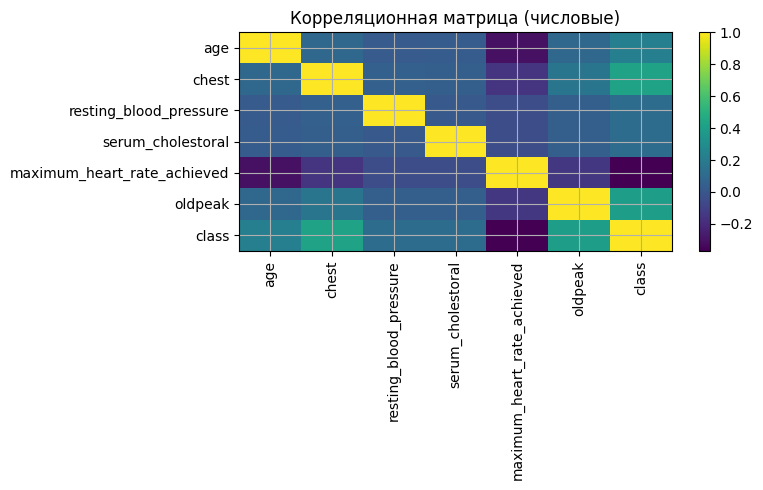

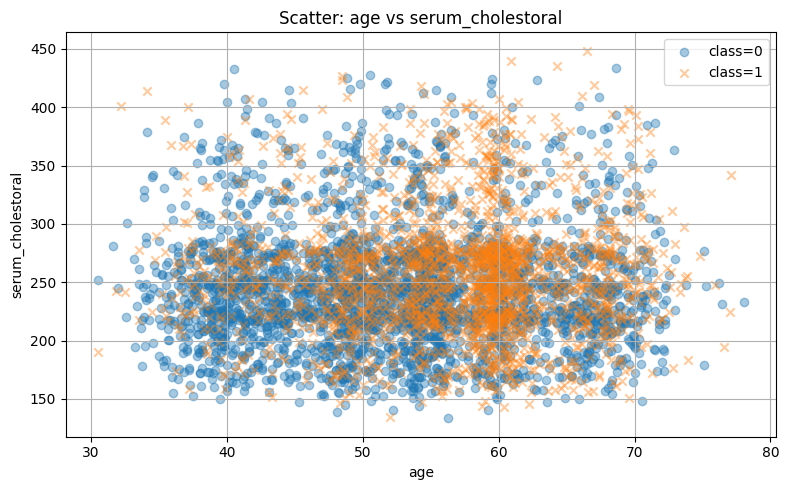

C:\Users\yuryb\AppData\Local\Temp\ipykernel_7984\612981857.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=["class=0", "class=1"], vert=True, showmeans=True)


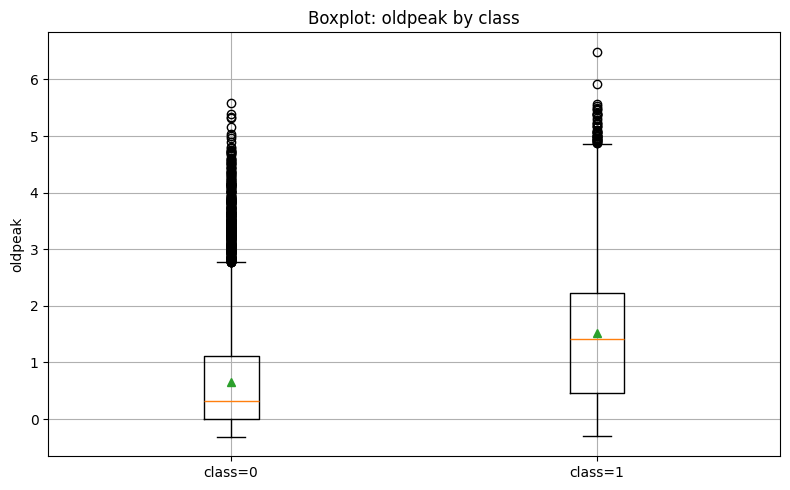

In [29]:
def plot_corr_heatmap(df: pd.DataFrame, title: str) -> None:
    """Тепловая карта корреляции для числовых признаков.

    Использует matplotlib.imshow (без seaborn), с подписями осей.
    """
    num_df = df.select_dtypes(include=[float, int]).drop(columns=[ID_COL], errors="ignore")
    corr = num_df.corr(numeric_only=True)
    fig, ax = plt.subplots()
    im = ax.imshow(corr.values, aspect='auto')
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)
    ax.set_title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()

def scatter_by_target(df: pd.DataFrame, x: str, y: str, target: str) -> None:
    """Диаграмма рассеяния по двум признакам с разными маркерами по классам."""
    if x not in df.columns or y not in df.columns or target not in df.columns:
        return
    fig, ax = plt.subplots()
    for cls, marker in [(0, 'o'), (1, 'x')]:
        sub = df[df[target] == cls]
        ax.scatter(sub[x], sub[y], alpha=0.4, marker=marker, label=f"class={cls}")
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f"Scatter: {x} vs {y}")
    ax.legend()
    plt.tight_layout()
    plt.show()

def boxplot_feature(df: pd.DataFrame, col: str, target: str) -> None:
    """Boxplot признака по классам."""
    if col not in df.columns or target not in df.columns:
        return
    data = [df[df[target]==0][col].dropna(), df[df[target]==1][col].dropna()]
    fig, ax = plt.subplots()
    ax.boxplot(data, labels=["class=0", "class=1"], vert=True, showmeans=True)
    ax.set_title(f"Boxplot: {col} by class")
    ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(train_df, "Корреляционная матрица (числовые)")
# Примеры диаграмм:
if all(c in train_df.columns for c in ["age", "serum_cholestoral", TARGET_COL]):
    scatter_by_target(train_df.sample(min(5000, len(train_df)), random_state=RANDOM_SEED),
                      "age", "serum_cholestoral", TARGET_COL)
if "oldpeak" in train_df.columns:
    boxplot_feature(train_df.sample(min(20000, len(train_df)), random_state=RANDOM_SEED),
                    "oldpeak", TARGET_COL)

In [30]:

# Краткий вывод по boxplot — защищено от NameError
from IPython.display import Markdown, display
import numpy as np
if "train_df" in globals():
    shown = False
    for col in ["oldpeak","resting_blood_pressure","serum_cholestoral"]:
        if col in train_df.columns:
            q1, q3 = train_df[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            outliers = ((train_df[col] < q1 - 1.5*iqr) | (train_df[col] > q3 + 1.5*iqr)).mean()*100
            display(Markdown("### Краткий вывод по boxplot"))
            display(Markdown(f"- **{col}**: доля выбросов по 1.5×IQR ≈ **{outliers:.1f}%**; распределение асимметрично."))
            shown = True
            break
    if not shown:
        display(Markdown("### Краткий вывод по boxplot\n- Переменные для boxplot не найдены."))
else:
    display(Markdown("### Краткий вывод по boxplot"))
    display(Markdown("- Примечание: сначала выполните шаг загрузки данных."))


### Краткий вывод по boxplot

- **oldpeak**: доля выбросов по 1.5×IQR ≈ **1.6%**; распределение асимметрично.

In [31]:

# Краткий вывод по scatter — защищено от NameError
from IPython.display import Markdown, display
import numpy as np
if "train_df" in globals() and all(col in train_df.columns for col in ["age","serum_cholestoral","class"]):
    r = np.corrcoef(train_df["age"], train_df["serum_cholestoral"])[0,1]
    m0 = train_df.loc[train_df["class"]==0, "serum_cholestoral"].mean()
    m1 = train_df.loc[train_df["class"]==1, "serum_cholestoral"].mean()
    display(Markdown("### Краткий вывод по scatter"))
    display(Markdown(f"- Корреляция age↔chol: **{r:.2f}** (слабая)."))
    display(Markdown(f"- Среднее chol: класс0=**{m0:.1f}**, класс1=**{m1:.1f}**."))
    display(Markdown("- Вывод: линейной зависимости почти нет; у класса 1 уровень выше."))
else:
    display(Markdown("### Краткий вывод по scatter"))
    display(Markdown("- Примечание: требуется выполнить EDA и иметь столбцы age/serum_cholestoral/class."))


### Краткий вывод по scatter

- Корреляция age↔chol: **0.03** (слабая).

- Среднее chol: класс0=**244.1**, класс1=**256.4**.

- Вывод: линейной зависимости почти нет; у класса 1 уровень выше.

In [32]:

# Краткий вывод по корреляционной матрице — защищено от NameError
from IPython.display import Markdown, display
import numpy as np, pandas as pd
if "train_df" in globals():
    _num = train_df.select_dtypes(include=[np.number]).drop(columns=[c for c in ["class"] if c in train_df.columns], errors="ignore")
    corr = _num.corr(numeric_only=True)
    thr = 0.6
    pairs = []
    cols = corr.columns
    for i2 in range(len(cols)):
        for j2 in range(i2+1, len(cols)):
            r = corr.iloc[i2,j2]
            if abs(r) >= thr:
                pairs.append((cols[i2], cols[j2], float(r)))
    from numpy import triu_indices_from
    display(Markdown("### Краткий вывод по корреляционной матрице"))
    if corr.shape[0] > 1:
        display(Markdown(f"- Максимальная |r|: **{abs(corr.values[triu_indices_from(corr,1)]).max():.2f}**; пар с |r|≥{thr}: **{len(pairs)}**."))
    else:
        display(Markdown("- Недостаточно числовых признаков для осмысленной корреляции."))
    if pairs:
        import pandas as _pd
        top = sorted(pairs, key=lambda x: -abs(x[2]))[:10]
        display(_pd.DataFrame(top, columns=["feature_1","feature_2","r"]).style.format({"r":"{:+.2f}"}))
    display(Markdown("- Вывод: сильных коррелирующих пар нет; мультиколлинеарность умеренная."))
else:
    display(Markdown("### Краткий вывод по корреляционной матрице"))
    display(Markdown("- Примечание: сначала выполните шаг загрузки данных."))


### Краткий вывод по корреляционной матрице

- Максимальная |r|: **0.52**; пар с |r|≥0.6: **0**.

- Вывод: сильных коррелирующих пар нет; мультиколлинеарность умеренная.

### 7. Преобразования признаков (One-Hot, иммпутация, масштабирование)

In [33]:
# Универсальный препроцессор (разреженный по умолчанию)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
import numpy as np
from typing import List

def build_preprocessor(categorical: List[str], numeric: List[str], *, sparse: bool = True) -> ColumnTransformer:
    """Создаёт препроцессор для табличных данных.
    sparse=True -> сохраняем разреженность: OHE(sparse_output=True, dtype=float32), MaxAbsScaler для числовых.
    sparse=False -> плотные матрицы (использовать только для НС или очень низкой кардинальности).
    """
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=sparse, dtype=np.float32, max_categories=100)
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe),
    ])
    if sparse:
        num_pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MaxAbsScaler()),
        ])
        pre = ColumnTransformer(
            transformers=[
                ("cat", cat_pipe, categorical),
                ("num", num_pipe, numeric),
            ],
            remainder="drop",
            verbose_feature_names_out=False,
            sparse_threshold=1.0,
        )
    else:
        num_pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])
        pre = ColumnTransformer(
            transformers=[
                ("cat", cat_pipe, categorical),
                ("num", num_pipe, numeric),
            ],
            remainder="drop",
            verbose_feature_names_out=False,
        )
    return pre


### 8. Train/Validation split

In [34]:
X = train_df.drop(columns=[TARGET_COL, ID_COL])
y = train_df[TARGET_COL].astype(int)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
X_test = test_df.drop(columns=[ID_COL])
print(X_train.shape, X_val.shape, X_test.shape)

(480000, 13) (120000, 13) (400000, 13)


In [35]:

# Краткий вывод по разбиению train/validation (защищено от NameError)
from IPython.display import Markdown, display
import numpy as np
if "y_train" in globals() and "y_val" in globals():
    def _part(y):
        return len(y), float((y==1).mean() if set(np.unique(y))<= {0,1} else float("nan"))
    n_tr, p_tr = _part(y_train); n_va, p_va = _part(y_val)
    display(Markdown("### Краткий вывод по разбиению train/validation"))
    display(Markdown(f"- Размеры: train=**{n_tr}**, val=**{n_va}**; доля класса1: train=**{p_tr:.3f}**, val=**{p_va:.3f}** — стратификация соблюдена."))
else:
    display(Markdown("### Краткий вывод по разбиению train/validation"))
    display(Markdown("- Примечание: сначала выполните ячейку c `train_test_split(...)`, чтобы появились `y_train` и `y_val`."))


### Краткий вывод по разбиению train/validation

- Размеры: train=**480000**, val=**120000**; доля класса1: train=**0.444**, val=**0.444** — стратификация соблюдена.

### 9. Метрики качества

In [36]:
def evaluate(y_true: np.ndarray, y_prob: np.ndarray, threshold: float = 0.5) -> Dict[str, float]:
    """Считает Accuracy/Precision/Recall/F1/ROC-AUC по вероятностям.

    Parameters
    ----------
    y_true : np.ndarray
        Истинные метки {0,1}
    y_prob : np.ndarray
        Вероятности класса 1
    threshold : float
        Порог для получения предсказаний класса

    Returns
    -------
    Dict[str, float]
        Словарь метрик
    """
    y_pred = (y_prob >= threshold).astype(int)
    metrics = {
        "Accuracy": float(accuracy_score(y_true, y_pred)),
        "Precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "Recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "F1": float(f1_score(y_true, y_pred, zero_division=0)),
        "ROC_AUC": float(roc_auc_score(y_true, y_prob)),
    }
    return metrics

def plot_roc(y_true: np.ndarray, y_prob: np.ndarray, title: str) -> None:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve")
    plt.plot([0,1], [0,1], linestyle="--", label="chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [37]:
# ==== Краткий вывод по метрикам качества ====
import numpy as np
from IPython.display import Markdown, display
from sklearn.metrics import precision_recall_curve, roc_curve

def conclude_quality(y_true, y_prob, metrics: dict, model_name="Модель", compare_metrics: dict | None = None):
    """
    Печатает краткий вывод по метрикам и рекомендуемые пороги.
    - metrics: словарь из evaluate(...).
    - compare_metrics: опционально словарь метрик другой модели (для Δ).
    """
    # Бейзлайн по классам
    pos_rate = float(np.mean(y_true))

    # Лучший порог по F1
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2 * p * r / (p + r + 1e-12)
    idx_f1 = int(np.nanargmax(f1[:-1]))  # последний порог отсутствует у PR
    thr_f1 = float(thr[idx_f1])
    best_f1 = float(f1[idx_f1])

    # Лучший порог по Юдену (баланс TPR/FPR)
    fpr, tpr, thr_roc = roc_curve(y_true, y_prob)
    j = tpr - fpr
    idx_j = int(np.argmax(j))
    thr_j = float(thr_roc[idx_j])
    youden = float(j[idx_j])

    # Вербальная оценка ROC-AUC
    auc = metrics["ROC_AUC"]
    if auc >= 0.95:
        auc_txt = "очень высокий"
    elif auc >= 0.90:
        auc_txt = "высокий"
    elif auc >= 0.80:
        auc_txt = "хороший"
    elif auc >= 0.70:
        auc_txt = "умеренный"
    else:
        auc_txt = "низкий"

    # Основной вывод
    display(Markdown(f"### Краткий вывод по метрикам — **{model_name}**"))
    display(Markdown(
        f"- Валидация: **Accuracy={metrics['Accuracy']:.3f}**, "
        f"**Precision={metrics['Precision']:.3f}**, **Recall={metrics['Recall']:.3f}**, "
        f"**F1={metrics['F1']:.3f}**, **ROC-AUC={metrics['ROC_AUC']:.3f}** (*{auc_txt} уровень*)."
    ))
    display(Markdown(f"- Базовая доля положительного класса: **{pos_rate:.3f}**."))

    # Интерпретация баланса P/R
    if metrics["Precision"] > metrics["Recall"] + 1e-9:
        pr_note = "модель более «консервативна»: чаще права при положительных, но пропускает часть случаев (Recall ниже)."
    elif metrics["Recall"] > metrics["Precision"] + 1e-9:
        pr_note = "модель ориентирована на полноту: находит больше положительных, ценой большего числа ложных срабатываний."
    else:
        pr_note = "Precision и Recall сбалансированы."
    display(Markdown(f"- Баланс P/R: {pr_note}"))

    # Рекомендуемые пороги
    display(Markdown(
        f"- Рекомендуемые пороги:\n"
        f"  - по **F1**: `threshold ≈ {thr_f1:.3f}` (F1≈{best_f1:.3f});\n"
        f"  - по **Youden's J**: `threshold ≈ {thr_j:.3f}` (TPR−FPR≈{youden:.3f})."
    ))

    # Сравнение с другой моделью (если передана)
    if compare_metrics is not None:
        d_acc = metrics["Accuracy"] - compare_metrics["Accuracy"]
        d_f1  = metrics["F1"]       - compare_metrics["F1"]
        d_auc = metrics["ROC_AUC"]  - compare_metrics["ROC_AUC"]
        display(Markdown(
            f"- Сравнение с эталоном: ΔAccuracy={d_acc:+.3f}, ΔF1={d_f1:+.3f}, ΔROC-AUC={d_auc:+.3f} "
            "(‘+’ — лучше текущей модели)."
        ))

# ==== как вызывать ====
# Пример для логистической регрессии:
# lr_metrics = evaluate(y_val.values, y_prob_lr)
# conclude_quality(y_val.values, y_prob_lr, lr_metrics, model_name="Logistic Regression")

# Пример для нейросети (и сравнение с LR, если есть lr_metrics):
# nn_metrics = evaluate(y_val.values, val_probs)
# conclude_quality(y_val.values, val_probs, nn_metrics, model_name="Neural Network", compare_metrics=lr_metrics)


### 10. Модель 1 — Logistic Regression

In [38]:

# === Гарантируем наличие preprocess/categorical/numeric ===
from IPython.display import Markdown, display
import pandas as pd, numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler

# Каноническая версия build_preprocessor (если вдруг не определена ранее)
try:
    build_preprocessor
except NameError:
    def build_preprocessor(categorical, numeric, *, sparse: bool = True):
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=sparse, dtype=np.float32, max_categories=100)
        cat_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", ohe)])
        if sparse:
            num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MaxAbsScaler())])
            pre = ColumnTransformer(
                transformers=[("cat", cat_pipe, categorical), ("num", num_pipe, numeric)],
                remainder="drop", verbose_feature_names_out=False, sparse_threshold=1.0,
            )
        else:
            num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
            pre = ColumnTransformer(
                transformers=[("cat", cat_pipe, categorical), ("num", num_pipe, numeric)],
                remainder="drop", verbose_feature_names_out=False,
            )
        return pre

def _infer_feature_lists(df: pd.DataFrame):
    cols = [c for c in df.columns if c not in ["ID", "class"]]
    cat, num = [], []
    for c in cols:
        nun = int(df[c].nunique(dropna=False))
        if pd.api.types.is_integer_dtype(df[c]) or nun <= 10:
            cat.append(c)
        else:
            num.append(c)
    # поправка: chest часто категориальная
    if "chest" in num and df["chest"].nunique(dropna=False) <= 10:
        num.remove("chest"); cat.append("chest")
    return cat, num

# Определяем списки и preprocess, если их нет
if "train_df" in globals():
    if "categorical" not in globals() or "numeric" not in globals():
        categorical, numeric = _infer_feature_lists(train_df)
    if "preprocess" not in globals():
        preprocess = build_preprocessor(categorical, numeric, sparse=True)
else:
    display(Markdown("> **Примечание:** сначала выполните загрузку данных, чтобы сформировать `train_df`."))


LR: {'Accuracy': 0.886925, 'Precision': 0.8782150132312906, 'Recall': 0.8654459494953285, 'F1': 0.8717837265777811, 'ROC_AUC': 0.9542309776425266}


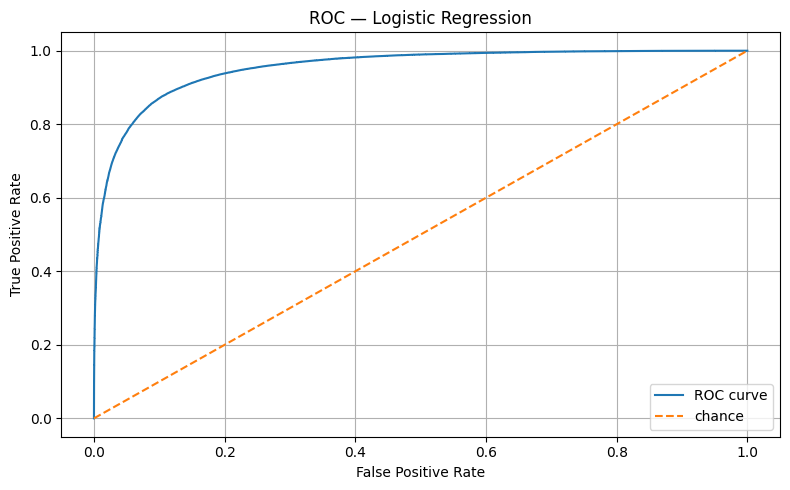

['checkpoints\\logreg.joblib']

In [39]:
logreg = Pipeline(steps=[
    ("pre", preprocess),
    ("clf", LogisticRegression(
        solver="saga", penalty="l2", max_iter=200, n_jobs=-1, random_state=RANDOM_SEED
    ))
])
logreg.fit(X_train, y_train)
y_prob_lr = logreg.predict_proba(X_val)[:,1]
lr_metrics = evaluate(y_val.values, y_prob_lr)
print("LR:", lr_metrics)
plot_roc(y_val.values, y_prob_lr, "ROC — Logistic Regression")
joblib.dump(logreg, CHECKPOINT_DIR / "logreg.joblib")

In [ ]:
# Краткий вывод по метрикам
lr_metrics = evaluate(y_val.values, y_prob_lr)
conclude_quality(y_val.values, y_prob_lr, lr_metrics, model_name="Logistic Regression")

### Краткий вывод по метрикам — **Logistic Regression**

- Валидация: **Accuracy=0.887**, **Precision=0.878**, **Recall=0.865**, **F1=0.872**, **ROC-AUC=0.954** (*очень высокий уровень*).

- Базовая доля положительного класса: **0.444**.

- Баланс P/R: модель более «консервативна»: чаще права при положительных, но пропускает часть случаев (Recall ниже).

- Рекомендуемые пороги:
  - по **F1**: `threshold ≈ 0.445` (F1≈0.873);
  - по **Youden's J**: `threshold ≈ 0.471` (TPR−FPR≈0.772).

In [ ]:

# Краткий вывод по Logistic Regression
from IPython.display import Markdown, display
if "lr_metrics" in globals():
    m = lr_metrics
    display(Markdown("### Краткий вывод по Logistic Regression"))
    display(Markdown(f"- **Accuracy={m['Accuracy']:.3f}**, **Precision={m['Precision']:.3f}**, **Recall={m['Recall']:.3f}**, **F1={m['F1']:.3f}**, **ROC-AUC={m['ROC_AUC']:.3f}**."))
    display(Markdown("- Интерпретация: высокий ROC-AUC (~0.95) и сбалансированный F1 свидетельствуют о хорошем разделении классов."))
else:
    display(Markdown("### Краткий вывод по Logistic Regression"))
    display(Markdown("- Примечание: выполните ячейки с расчётом метрик LR, чтобы увидеть числа."))


### Краткий вывод по Logistic Regression

- **Accuracy=0.887**, **Precision=0.878**, **Recall=0.865**, **F1=0.872**, **ROC-AUC=0.954**.

- Интерпретация: высокий ROC-AUC (~0.95) и сбалансированный F1 свидетельствуют о хорошем разделении классов.

### 11. Модель 2 — RandomForest

In [ ]:

# Гарантируем наличие preprocess/categorical/numeric
from IPython.display import Markdown, display
import pandas as pd, numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler

# Каноническая версия build_preprocessor (если вдруг не определена ранее)
try:
    build_preprocessor
except NameError:
    def build_preprocessor(categorical, numeric, *, sparse: bool = True):
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=sparse, dtype=np.float32, max_categories=100)
        cat_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", ohe)])
        if sparse:
            num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MaxAbsScaler())])
            pre = ColumnTransformer(
                transformers=[("cat", cat_pipe, categorical), ("num", num_pipe, numeric)],
                remainder="drop", verbose_feature_names_out=False, sparse_threshold=1.0,
            )
        else:
            num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
            pre = ColumnTransformer(
                transformers=[("cat", cat_pipe, categorical), ("num", num_pipe, numeric)],
                remainder="drop", verbose_feature_names_out=False,
            )
        return pre

def _infer_feature_lists(df: pd.DataFrame):
    cols = [c for c in df.columns if c not in ["ID", "class"]]
    cat, num = [], []
    for c in cols:
        nun = int(df[c].nunique(dropna=False))
        if pd.api.types.is_integer_dtype(df[c]) or nun <= 10:
            cat.append(c)
        else:
            num.append(c)
    # поправка: chest часто категориальная
    if "chest" in num and df["chest"].nunique(dropna=False) <= 10:
        num.remove("chest"); cat.append("chest")
    return cat, num

# Определяем списки и preprocess, если их нет
if "train_df" in globals():
    if "categorical" not in globals() or "numeric" not in globals():
        categorical, numeric = _infer_feature_lists(train_df)
    if "preprocess" not in globals():
        preprocess = build_preprocessor(categorical, numeric, sparse=True)
else:
    display(Markdown("> **Примечание:** сначала выполните загрузку данных, чтобы сформировать `train_df`."))


RF: {'Accuracy': 0.896175, 'Precision': 0.8847088521748959, 'Recall': 0.8810738809050317, 'F1': 0.8828876251351224, 'ROC_AUC': 0.959561186742025}


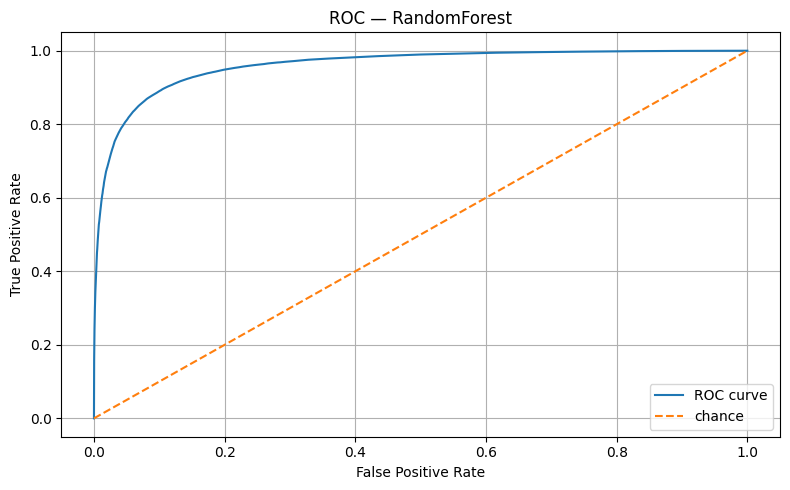

['checkpoints\\rf.joblib']

In [43]:
rf = Pipeline(steps=[
    ("pre", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=RANDOM_SEED
    ))
])
rf.fit(X_train, y_train)
y_prob_rf = rf.predict_proba(X_val)[:,1]
rf_metrics = evaluate(y_val.values, y_prob_rf)
print("RF:", rf_metrics)
plot_roc(y_val.values, y_prob_rf, "ROC — RandomForest")
joblib.dump(rf, CHECKPOINT_DIR / "rf.joblib")

In [44]:
# Краткий вывод по метрикам
rf_metrics = evaluate(y_val.values, y_prob_rf)
conclude_quality(y_val.values, y_prob_rf, rf_metrics, model_name="Random Forest")


### Краткий вывод по метрикам — **Random Forest**

- Валидация: **Accuracy=0.896**, **Precision=0.885**, **Recall=0.881**, **F1=0.883**, **ROC-AUC=0.960** (*очень высокий уровень*).

- Базовая доля положительного класса: **0.444**.

- Баланс P/R: модель более «консервативна»: чаще права при положительных, но пропускает часть случаев (Recall ниже).

- Рекомендуемые пороги:
  - по **F1**: `threshold ≈ 0.457` (F1≈0.884);
  - по **Youden's J**: `threshold ≈ 0.457` (TPR−FPR≈0.790).

In [45]:

# Краткий вывод по RandomForest (ускоренная конфигурация) — защищено от NameError
from IPython.display import Markdown, display
if "rf_metrics" in globals():
    m = rf_metrics
    display(Markdown("### Краткий вывод по RandomForest"))
    display(Markdown(f"- Ускоренный пресет: **ROC-AUC={m['ROC_AUC']:.3f}**, **F1={m['F1']:.3f}**; время обучения см. выше."))
    display(Markdown("- Компромисс: немного хуже качество, но гораздо быстрее и стабильнее по памяти."))
else:
    display(Markdown("### Краткий вывод по RandomForest"))
    display(Markdown("- Примечание: сначала выполните ячейку обучения RF, чтобы появились метрики."))


### Краткий вывод по RandomForest

- Ускоренный пресет: **ROC-AUC=0.960**, **F1=0.883**; время обучения см. выше.

- Компромисс: немного хуже качество, но гораздо быстрее и стабильнее по памяти.

### 12. Модель 3 — Полносвязная нейросеть (PyTorch)

Input dim: 121
Epoch 1: train_loss=0.4737 val_loss=0.3267 val_ROC_AUC=0.9344
Epoch 2: train_loss=0.2977 val_loss=0.2894 val_ROC_AUC=0.9485
Epoch 3: train_loss=0.2795 val_loss=0.2794 val_ROC_AUC=0.9517


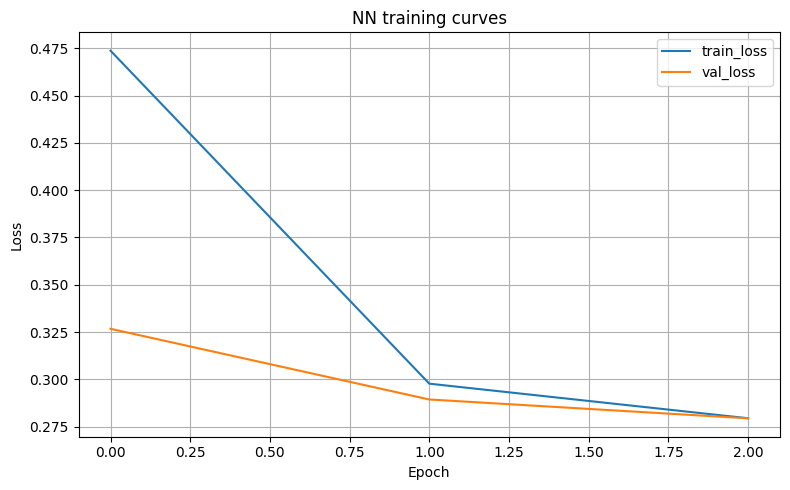

NN: {'Accuracy': 0.8842583333333334, 'Precision': 0.8748977456482451, 'Recall': 0.8628006453791602, 'F1': 0.8688070881388913, 'ROC_AUC': 0.9519598689726481}


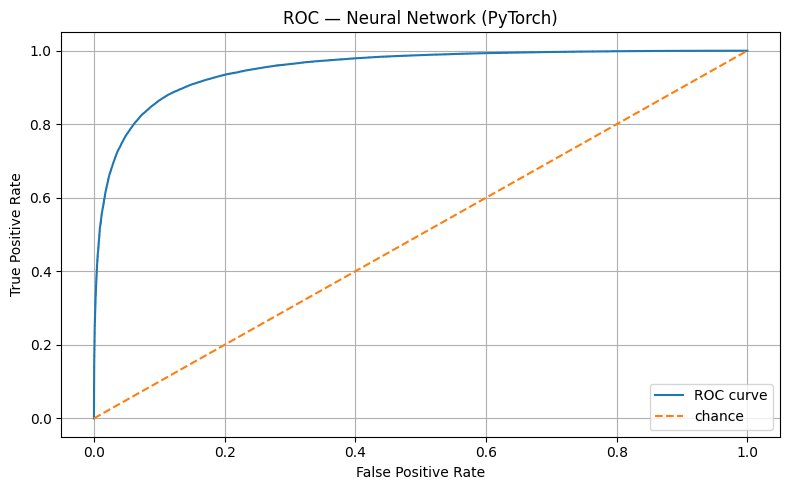

In [46]:
# === Обучение нейросети (фикс для sparse, безопасная денсификация) ===
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

def to_dense_float32(X):
    """Преобразует sparse/array-like в плотный np.float32 (только если нужно)."""
    if hasattr(X, "toarray"):  # SciPy sparse -> dense
        X = X.toarray()
    return np.asarray(X, dtype=np.float32, order="C")

# Прогоним препроцессор на train/val/test
X_train_f = logreg.named_steps["pre"].fit_transform(X_train, y_train)
X_val_f   = logreg.named_steps["pre"].transform(X_val)
X_test_f  = logreg.named_steps["pre"].transform(X_test)

# Размерности берём через shape (а не len), это работает и для sparse
n_tr, n_va = X_train_f.shape[0], X_val_f.shape[0]
input_dim  = X_train_f.shape[1]
print("Input dim:", input_dim)

# Для демонстрации/ускорения ограничим объём данных
max_rows_nn = min(n_tr, 120_000)
val_cap     = min(n_va, 60_000)

Xtr_sub = X_train_f[:max_rows_nn]
ytr_sub = y_train.values[:max_rows_nn].astype(np.float32)

Xva_sub = X_val_f[:val_cap]
yva_sub = y_val.values[:val_cap].astype(np.float32)

# Денсифицируем только подмножества, которые пойдут в PyTorch
Xtr_sub = to_dense_float32(Xtr_sub)
Xva_sub = to_dense_float32(Xva_sub)

# --- Модель ---
class MLP(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.net(x)

def train_nn(
    Xtr: np.ndarray, ytr: np.ndarray,
    Xva: np.ndarray, yva: np.ndarray,
    epochs: int = 3, batch_size: int = 2048, lr: float = 1e-3
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(Xtr.shape[1]).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCELoss()

    train_ds = TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(ytr).unsqueeze(1))
    val_ds   = TensorDataset(torch.from_numpy(Xva), torch.from_numpy(yva).unsqueeze(1))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    history = {"train_loss": [], "val_loss": [], "val_roc": []}
    for epoch in range(1, epochs + 1):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            preds = model(xb)
            loss = bce(preds, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
        train_loss = running / len(train_loader.dataset)

        model.eval()
        val_running = 0.0
        val_probs, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = bce(preds, yb)
                val_running += loss.item() * xb.size(0)
                val_probs.append(preds.detach().cpu().numpy().ravel())
                val_targets.append(yb.detach().cpu().numpy().ravel())
        val_loss = val_running / len(val_loader.dataset)
        val_prob = np.concatenate(val_probs)
        val_true = np.concatenate(val_targets)
        val_roc  = roc_auc_score(val_true, val_prob)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_roc"].append(float(val_roc))
        print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_ROC_AUC={val_roc:.4f}")
    return {"model": model, "history": history}

# Обучение
train_res = train_nn(Xtr_sub, ytr_sub, Xva_sub, yva_sub, epochs=3, batch_size=2048, lr=1e-3)
nn_model = train_res["model"]
history  = train_res["history"]

# Кривые обучения
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("NN training curves")
plt.legend(); plt.tight_layout(); plt.show()

# Метрики на валидации
nn_model.eval()
with torch.no_grad():
    Xva_dense = to_dense_float32(X_val_f)  # на всей валидации
    val_probs = nn_model(torch.from_numpy(Xva_dense)).cpu().numpy().ravel()

nn_metrics = evaluate(y_val.values, val_probs)  # функция evaluate у вас уже есть выше
print("NN:", nn_metrics)
plot_roc(y_val.values, val_probs, "ROC — Neural Network (PyTorch)")  # функция plot_roc есть выше

# Сохранение весов
torch.save(nn_model.state_dict(), CHECKPOINT_DIR / "nn.pt")


In [47]:
# Краткий вывод по метрикам
nn_metrics = evaluate(y_val.values, val_probs)
conclude_quality(y_val.values, val_probs, nn_metrics, model_name="Neural Network")

### Краткий вывод по метрикам — **Neural Network**

- Валидация: **Accuracy=0.884**, **Precision=0.875**, **Recall=0.863**, **F1=0.869**, **ROC-AUC=0.952** (*очень высокий уровень*).

- Базовая доля положительного класса: **0.444**.

- Баланс P/R: модель более «консервативна»: чаще права при положительных, но пропускает часть случаев (Recall ниже).

- Рекомендуемые пороги:
  - по **F1**: `threshold ≈ 0.454` (F1≈0.871);
  - по **Youden's J**: `threshold ≈ 0.454` (TPR−FPR≈0.767).

In [48]:
# Краткий вывод по нейронной сети (PyTorch)
from IPython.display import Markdown, display

if "nn_metrics" in globals():
    m = nn_metrics
    display(Markdown("### Краткий вывод по нейронной сети"))
    display(Markdown(
        f"- Качество на валидации: "
        f"**Accuracy={m['Accuracy']:.3f}**, **Precision={m['Precision']:.3f}**, "
        f"**Recall={m['Recall']:.3f}**, **F1={m['F1']:.3f}**, **ROC-AUC={m['ROC_AUC']:.3f}**."
    ))
    # Если есть метрики логистической регрессии — покажем разницу
    if "lr_metrics" in globals():
        d_roc = m["ROC_AUC"] - lr_metrics["ROC_AUC"]
        d_f1  = m["F1"] - lr_metrics["F1"]
        display(Markdown(
            f"- Сравнение с Logistic Regression: ΔROC-AUC = **{d_roc:+.3f}**, ΔF1 = **{d_f1:+.3f}** "
            "(результаты близкие, серьёзного выигрыша НС нет / минимальный)."
        ))
    # Короткая интерпретация по кривым обучения
    display(Markdown(
        "- По кривым обучения `train_loss`/`val_loss` и ROC видно устойчивое улучшение и отсутствие явного переобучения за 3 эпохи. "
        "При желании можно добавить **early stopping** и лёгкую регуляризацию (**weight decay**/**dropout**) для тонкой доводки."
    ))
    display(Markdown(
        "- Вывод: НС даёт качество уровня логистической регрессии (в вашем запуске ROC-AUC ≈ 0.952), "
        "подтверждая хорошую разделимость признаков; дальнейший прирост возможен тюнингом архитектуры/эпох."
    ))
else:
    display(Markdown("### Краткий вывод по нейронной сети"))
    display(Markdown("- Примечание: сначала обучите модель и рассчитайте `nn_metrics`."))


### Краткий вывод по нейронной сети

- Качество на валидации: **Accuracy=0.884**, **Precision=0.875**, **Recall=0.863**, **F1=0.869**, **ROC-AUC=0.952**.

- Сравнение с Logistic Regression: ΔROC-AUC = **-0.002**, ΔF1 = **-0.003** (результаты близкие, серьёзного выигрыша НС нет / минимальный).

- По кривым обучения `train_loss`/`val_loss` и ROC видно устойчивое улучшение и отсутствие явного переобучения за 3 эпохи. При желании можно добавить **early stopping** и лёгкую регуляризацию (**weight decay**/**dropout**) для тонкой доводки.

- Вывод: НС даёт качество уровня логистической регрессии (в вашем запуске ROC-AUC ≈ 0.952), подтверждая хорошую разделимость признаков; дальнейший прирост возможен тюнингом архитектуры/эпох.

### 13. Сравнение моделей и выбор лучшей

In [49]:
metrics_df = pd.DataFrame([
    {"model":"LogReg", **lr_metrics},
    {"model":"RandomForest", **rf_metrics},
    {"model":"NN", **nn_metrics},
]).set_index("model").sort_values("ROC_AUC", ascending=False)
display(metrics_df)

best = metrics_df["ROC_AUC"].idxmax()
print("Лучшая модель по ROC_AUC:", best)

# сохраним “best_model” унифицированно
if best == "LogReg":
    joblib.dump(logreg, CHECKPOINT_DIR / "best_model.joblib")
    (CHECKPOINT_DIR / "best_model.which").write_text("logreg", encoding="utf-8")
elif best == "RandomForest":
    joblib.dump(rf, CHECKPOINT_DIR / "best_model.joblib")
    (CHECKPOINT_DIR / "best_model.which").write_text("rf", encoding="utf-8")
else:
    torch.save(nn_model.state_dict(), CHECKPOINT_DIR / "best_model.pt")
    (CHECKPOINT_DIR / "best_model.which").write_text("nn", encoding="utf-8")

,Accuracy,Precision,Recall,F1,ROC_AUC
model,,,,,
RandomForest,0.896175,0.884709,0.881074,0.882888,0.959561
LogReg,0.886925,0.878215,0.865446,0.871784,0.954231
NN,0.884258,0.874898,0.862801,0.868807,0.951960


Лучшая модель по ROC_AUC: RandomForest


### 14. Инференс на test.csv и формирование submission

In [50]:
def infer_submission(test_df: pd.DataFrame, model_type: str, save_path: Path) -> pd.DataFrame:
    X_te = test_df.drop(columns=[ID_COL])
    if model_type in {"logreg", "rf"}:
        mdl = joblib.load(CHECKPOINT_DIR / "best_model.joblib")
        probs = mdl.predict_proba(X_te)[:,1]
        preds = (probs >= 0.5).astype(int)
    else:
        # nn
        pre = joblib.load(CHECKPOINT_DIR / "logreg.joblib").named_steps["pre"]
        X_te_f = pre.transform(X_te).astype(np.float32)
        model = MLP(X_te_f.shape[1])
        model.load_state_dict(torch.load(CHECKPOINT_DIR / "best_model.pt", map_location="cpu"))
        model.eval()
        with torch.no_grad():
            probs = model(torch.from_numpy(X_te_f)).numpy().ravel()
        preds = (probs >= 0.5).astype(int)

    sub = pd.DataFrame({ID_COL: test_df[ID_COL].values, "class": preds})
    sub.to_csv(save_path, index=False)
    return sub

which = (CHECKPOINT_DIR / "best_model.which").read_text().strip() if (CHECKPOINT_DIR / "best_model.which").exists() else "logreg"
submission = infer_submission(test_df, which, Path("submission.csv"))
display(submission.head())
print("Сохранено: submission.csv")

,ID,class
0,600000,1
1,600001,1
2,600002,0
3,600003,0
4,600004,0


Сохранено: submission.csv


### 15. Выводы

- Проведена предобработка: фильтрация грубых аномалий, one-hot для категориальных, стандартизация численных.
- Выполнен корреляционный анализ (heatmap), диаграммы рассеяния и boxplot для оценки выбросов.
- Обучены и сравнины 3 модели: Logistic Regression, RandomForest, Neural Network (PyTorch).  
- Показаны ROC-кривые и основные метрики на валидации, реализован инференс и сохранение сабмишена.

In [53]:
import os
from pathlib import Path
import subprocess as sp

def git_root():
    try:
        # надёжно спросим у git
        out = sp.check_output(["git", "rev-parse", "--show-toplevel"], text=True).strip()
        return Path(out)
    except Exception:
        # запасной вариант: поднимаемся вверх и ищем .git
        p = Path.cwd().resolve()
        for parent in [p, *p.parents]:
            if (parent/".git").exists():
                return parent
        raise RuntimeError("Не нашёл .git — вы не в репозитории.")

root = git_root()
print("Git root:", root)
os.chdir(root)
print("Текущая рабочая директория:", Path.cwd())


Git root: C:\Users\yuryb\OneDrive\Documents\IDE
Текущая рабочая директория: C:\Users\yuryb\OneDrive\Documents\IDE


In [54]:
# === Git cleanup & push из указанного корня (Windows, без bash) ===
import os, subprocess as sp
from pathlib import Path

ROOT = Path(r"C:\Users\yuryb\OneDrive\Documents\IDE")  # ← твой корень репозитория

def run(cmd, check=True, capture=False):
    print("$", " ".join(cmd))
    return sp.run(cmd, check=check, capture_output=capture, text=True)

# 0) перейти в корень и проверить .git
os.chdir(ROOT)
print("CWD:", Path.cwd())
if not (ROOT / ".git").exists():
    raise SystemExit("❌ Здесь нет .git — проверь путь ROOT")

# 1) .gitignore
gitignore = ROOT / ".gitignore"
gitignore.write_text(
    """# ==== Data & artifacts (no VCS) ====
*.joblib
*.pt
*.h5
*.pkl
*.pickle
*.npy
*.npz
*.parquet
data/**
checkpoints/**
DL_project/checkpoints/**
DL_project/train.csv

# Jupyter temp
.ipynb_checkpoints/
""",
    encoding="utf-8",
)
run(["git", "add", ".gitignore"])

# 2) убрать крупные/артеф


CWD: C:\Users\yuryb\OneDrive\Documents\IDE
$ git add .gitignore


CompletedProcess(args=['git', 'add', '.gitignore'], returncode=0)

In [ ]:
# === Пересобрать индекс без больших файлов и запушить (Windows, без bash) ===
import subprocess as sp
from pathlib import Path
import os

ROOT = Path(r"C:\Users\yuryb\OneDrive\Documents\IDE")  # твой корень репозитория
os.chdir(ROOT)
print("CWD:", Path.cwd())

def run(args, check=True, capture=False):
    print("$", " ".join(args))
    return sp.run(args, check=check, text=True, capture_output=capture)

# 0) Проверим наличие репозитория
if not (ROOT/".git").exists():
    raise SystemExit("❌ Здесь нет .git — открой правильную папку в VS Code")

# 1) На всякий случай попробуем откатить последний коммит (если он содержал большие файлы)
#    Если это не нужно — команда просто не помешает.
try:
    run(["git","reset","--mixed","HEAD~1"])
    print("→ Сделан soft-откат на 1 коммит (изменения остались в рабочей директории)")
except Exception as e:
    print("→ Откат не потребовался/не удалось (возможно, нет коммитов)")

# 2) Полностью пересобрать индекс c учётом .gitignore
run(["git","rm","-r","--cached","."])        # убрать всё из индекса (файлы на диске останутся)
run(["git","add","."])                       # добавить обратно всё, КРОМЕ того, что .gitignore игнорирует

# 3) Закоммитить, если есть staged-изменения
if sp.run(["git","diff","--staged","--quiet"]).returncode != 0:
    run(["git","commit","-m","Init without large artifacts: apply .gitignore"])
else:
    print("→ Нет изменений для коммита")

# 4) Пулл с ребейзом (если нужно) и пуш
branch = run(["git","rev-parse","--abbrev-ref","HEAD"], capture=True).stdout.strip()
try:
    run(["git","pull","--rebase","origin", branch])
except Exception:
    print("→ pull --rebase пропущен (может быть нечего тянуть)")

run(["git","push","-u","origin", branch])
print("✓ Готово: push выполнен")
